In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import label_binarize, StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import load_digits


# https://www.codementor.io/mgalarny/making-your-first-machine-learning-classifier-in-scikit-learn-python-db7d7iqdh
# http://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html
# http://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html

# 3 Task

In [34]:
#mnist = fetch_mldata('MNIST original') имеют размер 28x28
#sz = 28
mnist = load_digits()
sz = 8

X, y = mnist.data, mnist.target
print(X.shape)

(1797, 64)


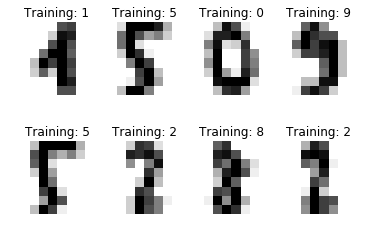

In [38]:
images_and_labels = list(zip(X, y))

for index, (image, label) in enumerate(images_and_labels[200:208]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image.reshape([sz,sz]), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

In [39]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,
random_state=17)

In [40]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

tree.fit(X_train, y_train)
knn.fit(X_train, y_train)

forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
print(np.mean(cross_val_score(forest, X_train, y_train, cv=5)))

0.9730268915667042


In [43]:
tree_pred = tree.predict(X_holdout)
print(accuracy_score(y_holdout, tree_pred))

knn_pred = knn.predict(X_holdout)
print(accuracy_score(y_holdout, knn_pred))

0.6666666666666666
0.9740740740740741


## Cross Val Tree

In [44]:
tree_params = {'max_depth': [2**i for i in range(6)],
'max_features': [2**i for i in range(6)]}

tree_grid = GridSearchCV(tree, tree_params,
cv=5, n_jobs=-1,
verbose=True)

In [45]:
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 2, 4, 8, 16, 32], 'max_features': [1, 2, 4, 8, 16, 32]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [46]:
print(tree_grid.best_params_, tree_grid.best_score_)

{'max_depth': 16, 'max_features': 32} 0.8400954653937948


In [47]:
print(accuracy_score(y_holdout, tree_grid.predict(X_holdout)))

0.8537037037037037


## Cross Val KNN

In [48]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

knn_params = {'knn__n_neighbors': range(1, 10)}

knn_grid = GridSearchCV(knn_pipe, knn_params,
cv=5, n_jobs=-1,
verbose=True)

In [49]:
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.0s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'knn__n_neighbors': range(1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [50]:
print(knn_grid.best_params_, knn_grid.best_score_)

{'knn__n_neighbors': 1} 0.9689737470167065


In [51]:
print(accuracy_score(y_holdout, knn_grid.predict(X_holdout)))

0.9703703703703703


## Cross Val Forest

In [52]:
forest_params = {'max_depth': [2**i for i in range(6)],
'max_features': [2**i for i in range(6)]}

forest_grid = GridSearchCV(forest, forest_params,
cv=5, n_jobs=-1,
verbose=True)

In [ ]:
forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s


In [19]:
print(forest_grid.best_params_, forest_grid.best_score_)

NameError: name 'forest_grid' is not defined

In [20]:
print(accuracy_score(y_holdout, forest_grid.predict(X_holdout)))

NameError: name 'y_holdout' is not defined